In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import warnings
import os

warnings.filterwarnings("ignore")
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["OMP_NUM_THREADS"] = "8"

# Zero-shot Learning

Zero-shot learning means new task can be accomplished without the need to retrain the model.

In [2]:
import lazyslide as zs

In [4]:
wsi = zs.datasets.lung_carcinoma(with_data=False)

WSI: /Users/yzheng/Library/Caches/lazyslide/lung_carcinoma.ndpi
Reader: openslide
Dimensions: 15616×16384 (h×w), 8 Pyramids
Pixel physical size: 0.22731405710129116 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1817, 1906)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
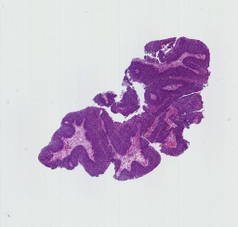

In [5]:
wsi

In [6]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 512, background_fraction=0.95, mpp=0.5)

## Zero-shot classification

We will first try to do zero-shot classification with conch, a text-image model

In [8]:
zs.tl.feature_extraction(wsi, "conch")

Output()

We need to prepare a set of classes to predict the probability.

In [13]:
classes = ["lung carcinoma", "breast carcinoma", "normal tissue"]

In [21]:
embeds = zs.tl.text_embedding(classes, model="conch")
zs.tl.text_image_similarity(wsi, embeds, model="conch")

We will use top-k scoring to decide the score of each classes.

In [26]:
scores = zs.metrics.topk_score(wsi["conch_tiles_text_similarity"], agg_method="mean")
for c, s in zip(classes, scores / scores.sum()):
    print(f"{c}: {s:.2f}")

lung carcinoma: 0.53
breast carcinoma: 0.18
normal tissue: 0.29


Alternatively, we can use Prism or Titan to query the probability directly.

The input of prism's slide encoder must come from virchow model

In [28]:
zs.tl.feature_extraction(wsi, "virchow")
zs.tl.feature_aggregation(wsi, feature_key="virchow", encoder="prism")

Output()

BioGptForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [33]:
zs.tl.zero_shot_score(wsi, classes, feature_key="virchow_tiles")

,lung carcinoma,breast carcinoma,normal tissue
0,0.910655,0.071339,0.018006


In [38]:
results = zs.tl.slide_caption(
    wsi, ["what is the diagnosis of the slide?"], feature_key="virchow_tiles"
)
results["caption"][0]

['</s>what is the diagnosis of the slide? </s>In situ squamous cell carcinoma with positive p16 and high-risk HPV. </s>']